### Normalizing Histone Signals

In [2]:
import pandas as pd

# Load the dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path)

# Extract histone marks columns (assuming the column names are known)
features = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# Describe the histone marks to check their distribution
feature_stats = df[features].describe()

feature_stats

,H3K4me1,H3K4me3,H3K27ac,H3K27me3,H3K9me3,H3K36me3,ESR1_signal,FOXA1_signal,GATA3_signal
count,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06,2.805747e+06
mean,9.284954e-01,1.619672e+00,1.876460e+00,4.284724e-01,3.267553e-01,5.210774e-01,1.474908e+00,1.019349e+00,3.090687e-01
std,3.873447e+00,1.450186e+01,1.610315e+01,1.078472e+00,6.554833e-01,1.607422e+00,5.757240e+01,2.961572e+01,1.654903e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.951391e-02,5.728266e-02,2.143730e-02,6.359958e-02,6.878579e-02,5.405681e-02,7.023200e-02,9.806640e-02,7.474053e-02
50%,5.903432e-02,1.048672e-01,4.698577e-02,1.653574e-01,1.522299e-01,1.066401e-01,1.666346e-01,2.314697e-01,1.574655e-01
75%,2.174493e-01,1.686104e-01,1.078025e-01,3.871549e-01,3.276268e-01,2.416798e-01,3.494827e-01,4.479365e-01,3.027141e-01
max,2.353819e+02,5.857773e+02,6.556597e+02,1.448525e+02,6.892392e+01,1.978991e+02,2.230684e+04,3.770827e+04,3.097888e+02


### Implementing Other Baseline Models for Chromatin Accessibility Prediction

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, brier_score_loss, classification_report, roc_auc_score, roc_curve, fbeta_score, balanced_accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3", 
           "ESR1_signal", "FOXA1_signal", "GATA3_signal"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")

# Drop any rows where chromatin_state is NaN after conversion
df = df.dropna(subset=["chromatin_state"])

# Convert to integer type
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Undersample majority class
minority = df[df["chromatin_state"] == 1]
majority = df[df["chromatin_state"] == 0].sample(n=22500, random_state=42)  # Reduce majority to 2000 samples
df = pd.concat([minority, majority]).sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset

# Print new class distribution
print("Class Distribution after Undersampling:")
print(df["chromatin_state"].value_counts())

# Extract features and target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]
X_histone = df[histone_marks]
X_tf = df[tf_signals]
y = df["chromatin_state"]

# Split into training, validation, and test sets (Ensuring no data leakage)
X_histone_train, X_histone_temp, X_tf_train, X_tf_temp, y_train, y_temp = train_test_split(
    X_histone, X_tf, y, test_size=0.30, random_state=42, stratify=y)
X_histone_val, X_histone_test, X_tf_val, X_tf_test, y_val, y_test = train_test_split(
    X_histone_temp, X_tf_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Normalize histone marks and TF signals (fit only on training set, transform on others)
scaler_histone = MinMaxScaler()
scaler_tf = MinMaxScaler()

X_histone_train = scaler_histone.fit_transform(X_histone_train)
X_histone_val = scaler_histone.transform(X_histone_val)
X_histone_test = scaler_histone.transform(X_histone_test)

X_tf_train = scaler_tf.fit_transform(X_tf_train)
X_tf_val = scaler_tf.transform(X_tf_val)
X_tf_test = scaler_tf.transform(X_tf_test)

# Convert back to DataFrame (optional, for easy inspection)
X_histone_train = pd.DataFrame(X_histone_train, columns=histone_marks)
X_histone_val = pd.DataFrame(X_histone_val, columns=histone_marks)
X_histone_test = pd.DataFrame(X_histone_test, columns=histone_marks)

X_tf_train = pd.DataFrame(X_tf_train, columns=tf_signals)
X_tf_val = pd.DataFrame(X_tf_val, columns=tf_signals)
X_tf_test = pd.DataFrame(X_tf_test, columns=tf_signals)

# Define models
models = {
    "Histogram Gradient Boosting": HistGradientBoostingClassifier(max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []
roc_curves = {}
classification_threshold = 0.3  # Adjust classification threshold

for model_name, model in models.items():
    print(f"Training {model_name}...")
    fold_results = []
    all_fprs, all_tprs = [], []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_histone_train, y_train)):
        X_fold_histone_train, X_fold_histone_test = X_histone_train.iloc[train_idx], X_histone_train.iloc[test_idx]
        X_fold_tf_train, X_fold_tf_test = X_tf_train.iloc[train_idx], X_tf_train.iloc[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # Concatenate both heads
        X_fold_train = np.hstack((X_fold_histone_train, X_fold_tf_train))
        X_fold_test = np.hstack((X_fold_histone_test, X_fold_tf_test))
        
        model.fit(X_fold_train, y_fold_train)
        y_pred_probs = model.predict_proba(X_fold_test)[:, 1]
        y_pred = (y_pred_probs > classification_threshold).astype(int)
        
        # Compute Metrics
        mcc = matthews_corrcoef(y_fold_test, y_pred)
        brier = brier_score_loss(y_fold_test, y_pred_probs)
        auc = roc_auc_score(y_fold_test, y_pred_probs)
        fpr, tpr, _ = roc_curve(y_fold_test, y_pred_probs)
        all_fprs.append(fpr)
        all_tprs.append(tpr)
        f2 = fbeta_score(y_fold_test, y_pred, beta=2)
        balanced_acc = balanced_accuracy_score(y_fold_test, y_pred)
        
        # Generate classification report
        class_report = classification_report(y_fold_test, y_pred, output_dict=True, zero_division=0)
        precision, recall, f1_score, support = class_report['1']['precision'], class_report['1']['recall'], class_report['1']['f1-score'], class_report['1']['support']
        
        fold_results.append({
            "Model": model_name,
            "Fold": fold + 1,
            "MCC": mcc,
            "Brier Score": brier,
            "AUC": auc,
            "FPR (1-Specificity)": fpr.mean(),
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1_score,
            "F2 Score": f2,
            "Balanced Accuracy": balanced_acc,
            "Support": support
        })
    
    results.extend(fold_results)
    roc_curves[model_name] = (all_fprs, all_tprs)

    # Test model on the holdout test set
    print(f"Evaluating {model_name} on Test Set...")
    X_test_combined = np.hstack((X_histone_test, X_tf_test))
    y_test_probs = model.predict_proba(X_test_combined)[:, 1]
    y_test_pred = (y_test_probs > classification_threshold).astype(int)
    
    test_auc = roc_auc_score(y_test, y_test_probs)
    test_mcc = matthews_corrcoef(y_test, y_test_pred)
    print(f"Test AUC: {test_auc:.4f}, Test MCC: {test_mcc:.4f}")
    print(classification_report(y_test, y_test_pred, zero_division=0))

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_8967/1839081521.py:15: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Class Distribution after Undersampling:
chromatin_state
0    22500
1     4405
Name: count, dtype: int64
Training Histogram Gradient Boosting...
Evaluating Histogram Gradient Boosting on Test Set...
Test AUC: 0.9944, Test MCC: 0.9128
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3375
           1       0.89      0.97      0.93       661

    accuracy                           0.97      4036
   macro avg       0.94      0.97      0.96      4036
weighted avg       0.98      0.97      0.98      4036

Training Logistic Regression...
Evaluating Logistic Regression on Test Set...
Test AUC: 0.9902, Test MCC: 0.8918
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3375
           1       0.86      0.96      0.91       661

    accuracy                           0.97      4036
   macro avg       0.93      0.96      0.94      4036
weighted avg       0.97      0.97      0.97      4036



### Results

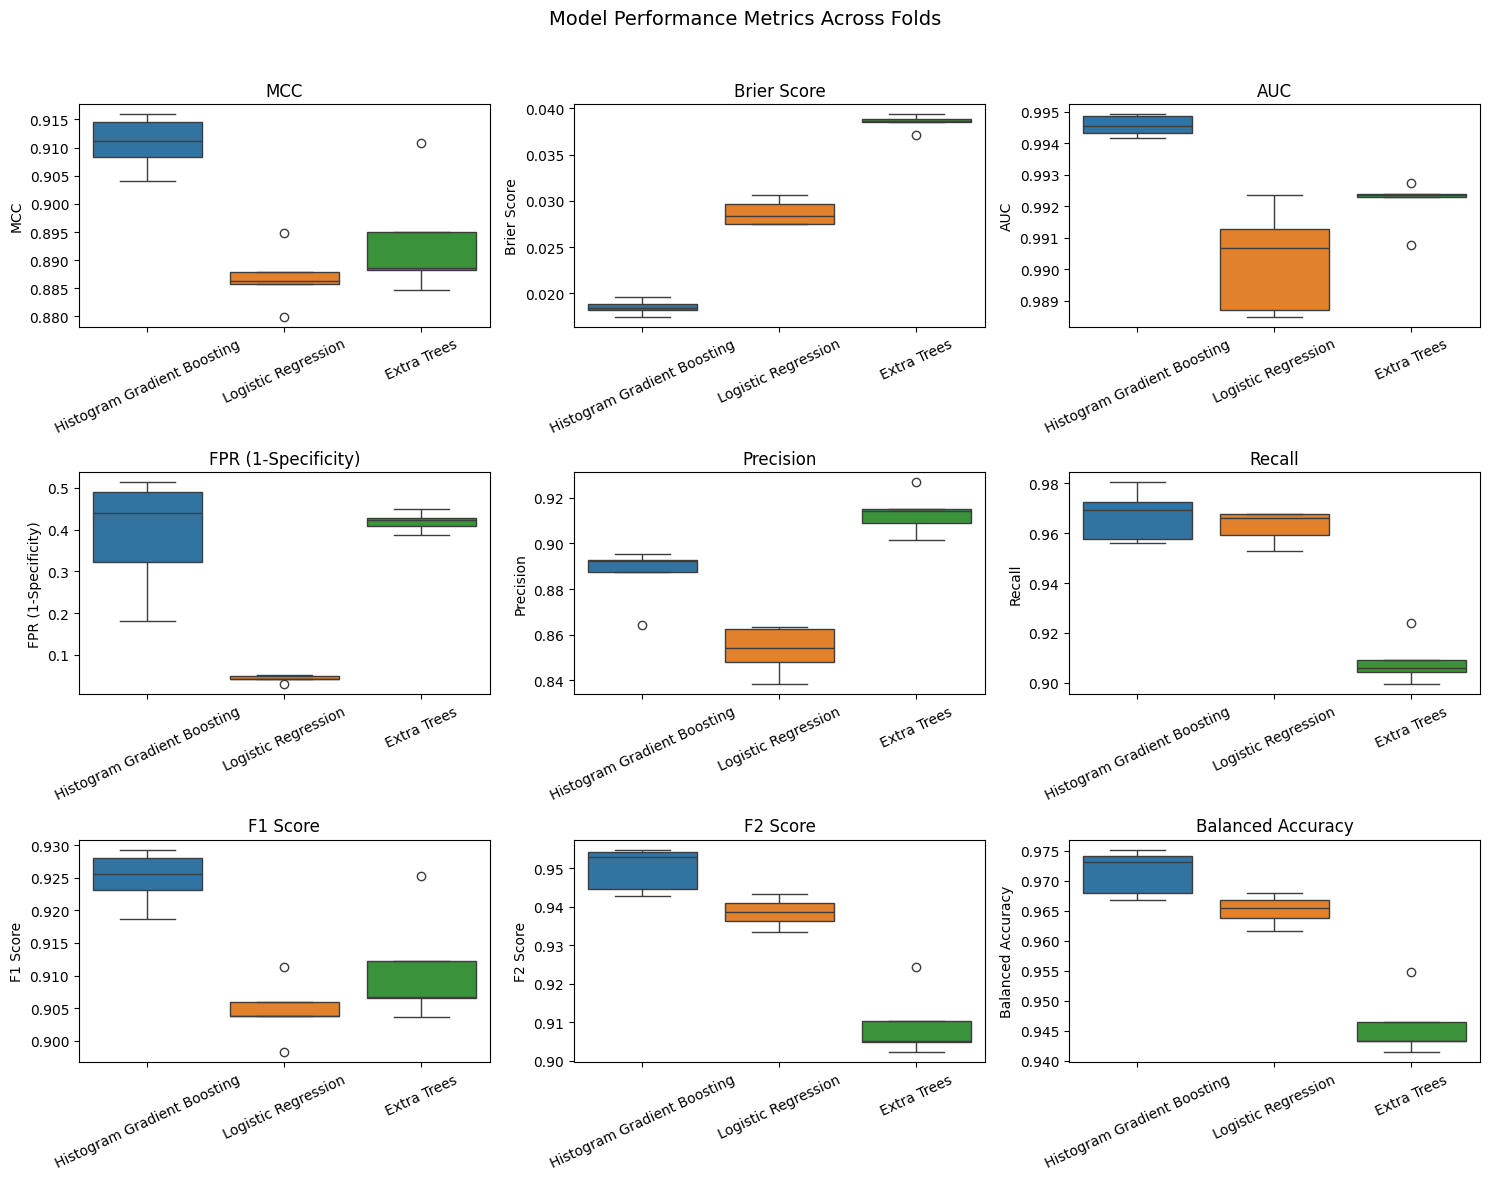

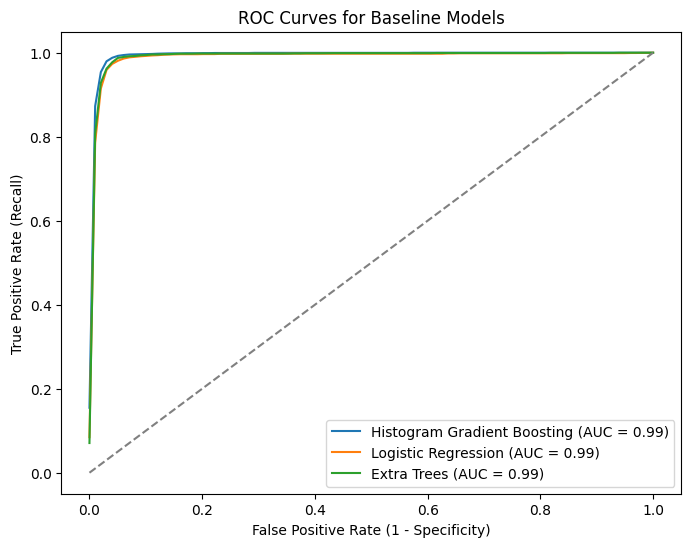

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualizing the results of model performance metrics
metrics = ["MCC", "Brier Score", "AUC", "FPR (1-Specificity)", "Precision", "Recall", "F1 Score", "F2 Score", "Balanced Accuracy"]

# Set up figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Model Performance Metrics Across Folds", fontsize=14)

# Generate plots for each metric
for ax, metric in zip(axes.flatten(), metrics):
    sns.boxplot(data=results_df, x="Model", y=metric, ax=ax, hue="Model")
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=25)  # Rotate x-axis labels to prevent overlap

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot ROC Curves for each model
plt.figure(figsize=(8, 6))
for model_name, (all_fprs, all_tprs) in roc_curves.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fprs, all_tprs)], axis=0)
    plt.plot(mean_fpr, mean_tpr, label=f"{model_name} (AUC = {np.mean([auc for auc in results_df[results_df['Model'] == model_name]['AUC']]):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for Baseline Models")
plt.legend()
plt.show()

### Multihead Neural Network (Train and Validation)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_8967/175725123.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Training Fold 1/3
Epoch 1/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9247 - loss: 0.2939 - val_accuracy: 0.9720 - val_loss: 0.0870
Epoch 2/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9711 - loss: 0.0911 - val_accuracy: 0.9728 - val_loss: 0.0841
Epoch 3/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9706 - loss: 0.0907 - val_accuracy: 0.9723 - val_loss: 0.0849
Epoch 4/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9725 - loss: 0.0823 - val_accuracy: 0.9717 - val_loss: 0.0826
Epoch 5/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9715 - loss: 0.0894 - val_accuracy: 0.9737 - val_loss: 0.0834
Epoch 6/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9730 - loss: 0.0795 - val_accuracy: 0.9748 - val_loss: 0.0814
Epoch 7/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9726 - loss: 0.0818 - val_accuracy: 0.9744 - val_loss: 0.0825
Epoch 8/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.0842 

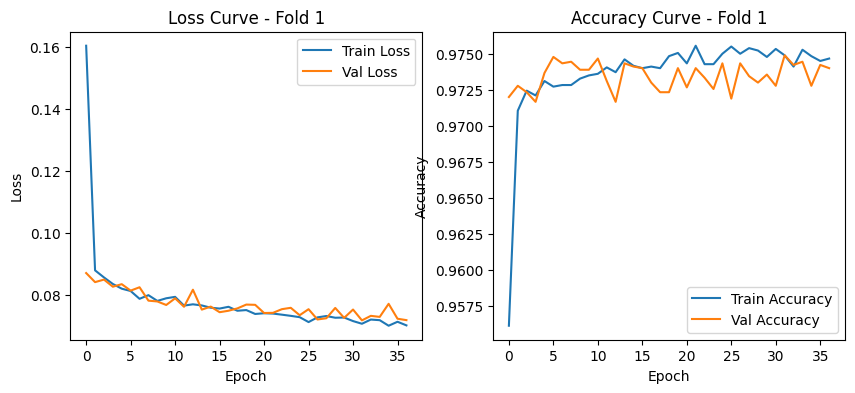

Training Fold 2/3
Epoch 1/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9204 - loss: 0.2744 - val_accuracy: 0.9712 - val_loss: 0.0848
Epoch 2/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9709 - loss: 0.0907 - val_accuracy: 0.9718 - val_loss: 0.0821
Epoch 3/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9721 - loss: 0.0863 - val_accuracy: 0.9727 - val_loss: 0.0817
Epoch 4/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9724 - loss: 0.0858 - val_accuracy: 0.9729 - val_loss: 0.0788
Epoch 5/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.0789 - val_accuracy: 0.9733 - val_loss: 0.0784
Epoch 6/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9726 - loss: 0.0838 - val_accuracy: 0.9731 - val_loss: 0.0771
Epoch 7/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9721 - loss: 0.0832 - val_accuracy: 0.9728 - val_loss: 0.0760
Epoch 8/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9723 - loss: 0.0806 

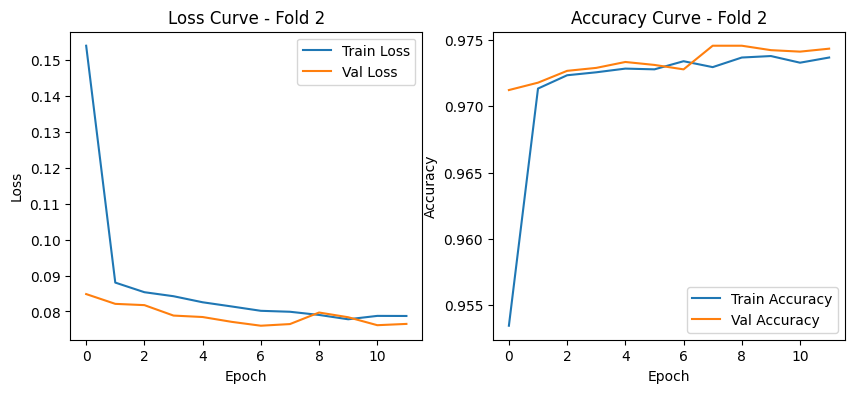

Training Fold 3/3
Epoch 1/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9179 - loss: 0.2871 - val_accuracy: 0.9709 - val_loss: 0.0879
Epoch 2/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.0962 - val_accuracy: 0.9716 - val_loss: 0.0803
Epoch 3/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9722 - loss: 0.0901 - val_accuracy: 0.9725 - val_loss: 0.0783
Epoch 4/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9723 - loss: 0.0872 - val_accuracy: 0.9727 - val_loss: 0.0767
Epoch 5/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.0849 - val_accuracy: 0.9725 - val_loss: 0.0773
Epoch 6/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9721 - loss: 0.0822 - val_accuracy: 0.9727 - val_loss: 0.0757
Epoch 7/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9746 - loss: 0.0829 - val_accuracy: 0.9727 - val_loss: 0.0762
Epoch 8/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.0829 

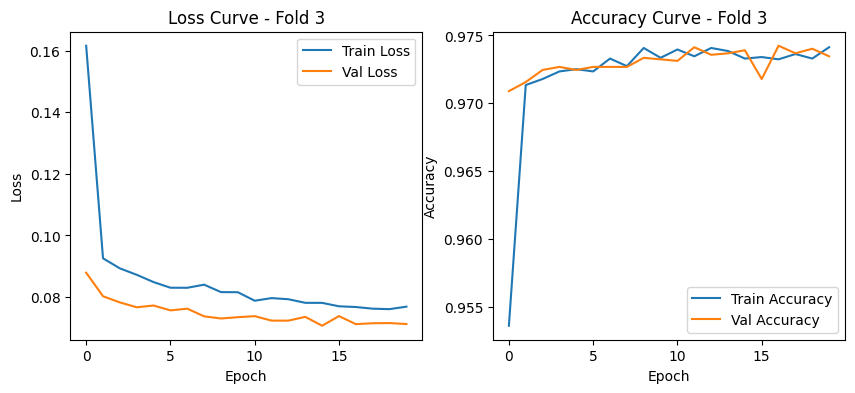

Cross-validation complete!


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, classification_report
import matplotlib.pyplot as plt

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
           "ESR1_signal", "FOXA1_signal", "GATA3_signal"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Undersample majority class
df_majority = df[df["chromatin_state"] == 0].sample(n=22500, random_state=42)
df_minority = df[df["chromatin_state"] == 1]
df_balanced = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)

# Extract features and target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]
X_histone = df_balanced[histone_marks]
X_tf = df_balanced[tf_signals]
y = df_balanced["chromatin_state"]

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_histone, y)):
    print(f"Training Fold {fold + 1}/3")

    # Split the data into training and validation sets
    X_hist_train, X_hist_val = X_histone.iloc[train_idx], X_histone.iloc[val_idx]
    X_tf_train, X_tf_val = X_tf.iloc[train_idx], X_tf.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Normalize histone marks and TF signals separately (fit only on training set)
    scaler_histone = MinMaxScaler()
    scaler_tf = MinMaxScaler()

    X_hist_train = scaler_histone.fit_transform(X_hist_train.values)
    X_hist_val = scaler_histone.transform(X_hist_val.values)

    X_tf_train = scaler_tf.fit_transform(X_tf_train.values)
    X_tf_val = scaler_tf.transform(X_tf_val.values)

    # Define Neural Network Model
    histone_input = Input(shape=(X_hist_train.shape[1],), name="Histone_Input")
    histone_dense = Dense(64, activation='relu')(histone_input)
    histone_dense = Dropout(0.3)(histone_dense)
    histone_dense = Dense(32, activation='relu')(histone_dense)

    tf_input = Input(shape=(X_tf_train.shape[1],), name="TF_Input")
    tf_dense = Dense(32, activation='relu')(tf_input)
    tf_dense = Dropout(0.3)(tf_dense)

    merged = Concatenate()([histone_dense, tf_dense])
    final_dense = Dense(32, activation='relu')(merged)
    final_dense = Dropout(0.3)(final_dense)
    out = Dense(1, activation='sigmoid', name="Output")(final_dense)

    model = Model(inputs=[histone_input, tf_input], outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit([X_hist_train, X_tf_train], y_train, epochs=50, batch_size=32,
                        validation_data=([X_hist_val, X_tf_val], y_val), callbacks=[early_stopping])

    # Store training history
    fold_results.append(history.history)

    # Plot training loss and accuracy for each fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curve - Fold {fold + 1}')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy Curve - Fold {fold + 1}')

    plt.show()

print("Cross-validation complete!")

### Multihead Neural Network (Train, Validation and Test)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_8967/1890547891.py:18: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Training Fold 1/5
Epoch 1/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9135 - loss: 0.2971 - val_accuracy: 0.9695 - val_loss: 0.0886
Epoch 2/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9677 - loss: 0.0972 - val_accuracy: 0.9716 - val_loss: 0.0847
Epoch 3/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9710 - loss: 0.0840 - val_accuracy: 0.9716 - val_loss: 0.0826
Epoch 4/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9686 - loss: 0.0858 - val_accuracy: 0.9713 - val_loss: 0.0826
Epoch 5/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.0778 - val_accuracy: 0.9719 - val_loss: 0.0805
Epoch 6/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9703 - loss: 0.0866 - val_accuracy: 0.9713 - val_loss: 0.0816
Epoch 7/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9703 - loss: 0.0846 - val_accuracy: 0.9708 - val_loss: 0.0790
Epoch 8/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9736 - loss: 0.0790 

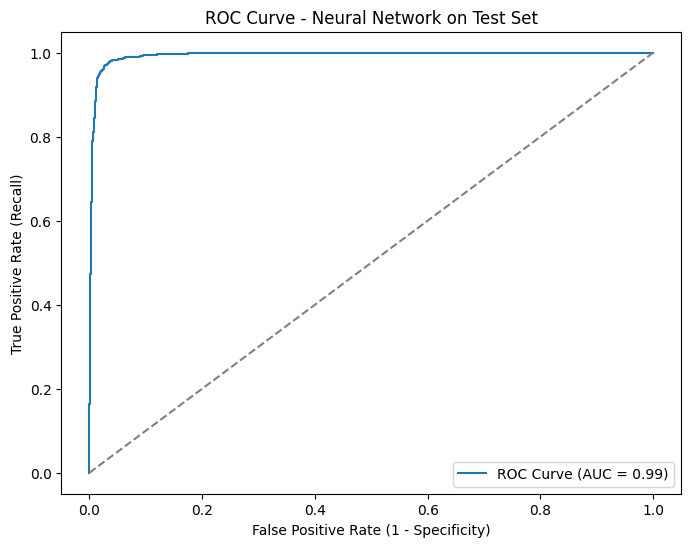

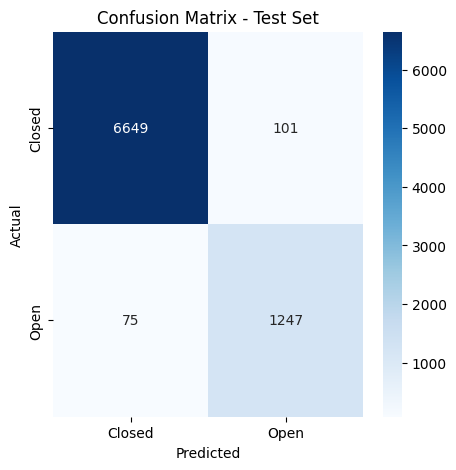

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
           "ESR1_signal", "FOXA1_signal", "GATA3_signal"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Undersample majority class for training
df_majority = df[df["chromatin_state"] == 0].sample(n=22500, random_state=42)
df_minority = df[df["chromatin_state"] == 1]
df_balanced = pd.concat([df_majority, df_minority]).sample(frac=1, random_state=42)

# Extract features and target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]
X_histone = df_balanced[histone_marks]
X_tf = df_balanced[tf_signals]
y = df_balanced["chromatin_state"]

# Split into training, validation, and test sets
X_hist_train, X_hist_test, X_tf_train, X_tf_test, y_train, y_test = train_test_split(
    X_histone, X_tf, y, test_size=0.30, random_state=42, stratify=y)

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_hist_train, y_train)):
    print(f"Training Fold {fold + 1}/5")

    # Split the data into training and validation sets
    X_hist_fold_train, X_hist_fold_val = X_hist_train.iloc[train_idx], X_hist_train.iloc[val_idx]
    X_tf_fold_train, X_tf_fold_val = X_tf_train.iloc[train_idx], X_tf_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Normalize histone marks and TF signals separately (fit only on training set)
    scaler_histone = MinMaxScaler()
    scaler_tf = MinMaxScaler()

    X_hist_fold_train = scaler_histone.fit_transform(X_hist_fold_train.values)
    X_hist_fold_val = scaler_histone.transform(X_hist_fold_val.values)

    X_tf_fold_train = scaler_tf.fit_transform(X_tf_fold_train.values)
    X_tf_fold_val = scaler_tf.transform(X_tf_fold_val.values)

    # Define Neural Network Model
    histone_input = Input(shape=(X_hist_fold_train.shape[1],), name="Histone_Input")
    histone_dense = Dense(64, activation='relu')(histone_input)
    histone_dense = Dropout(0.3)(histone_dense)
    histone_dense = Dense(32, activation='relu')(histone_dense)

    tf_input = Input(shape=(X_tf_fold_train.shape[1],), name="TF_Input")
    tf_dense = Dense(32, activation='relu')(tf_input)
    tf_dense = Dropout(0.3)(tf_dense)

    merged = Concatenate()([histone_dense, tf_dense])
    final_dense = Dense(32, activation='relu')(merged)
    final_dense = Dropout(0.3)(final_dense)
    out = Dense(1, activation='sigmoid', name="Output")(final_dense)

    model = Model(inputs=[histone_input, tf_input], outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit([X_hist_fold_train, X_tf_fold_train], y_fold_train, epochs=50, batch_size=32,
                        validation_data=([X_hist_fold_val, X_tf_fold_val], y_fold_val), callbacks=[early_stopping])

    # Store training history
    fold_results.append(history.history)

# Test Set Performance Metrics
X_hist_test = scaler_histone.transform(X_hist_test.values)
X_tf_test = scaler_tf.transform(X_tf_test.values)

y_test_probs = model.predict([X_hist_test, X_tf_test])
y_test_pred = (y_test_probs > 0.5).astype(int)

# Convert test labels to NumPy arrays before logical operations
y_test_pred = np.array(y_test_pred).flatten()
y_test = np.array(y_test).flatten()

# Compute Final Test Set Metrics
test_auc = roc_auc_score(y_test, y_test_probs)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)
test_fpr = np.sum((y_test_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

# Print Metrics
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MCC: {test_mcc:.4f}")
print(f"Test FPR (1 - Specificity): {test_fpr:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Neural Network on Test Set")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

### Permutation Feature Importance
- Measures how important each feature is by randomly shuffling one feature at a time and checking the impact on performance.
- Larger performance drops mean higher feature importance.

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


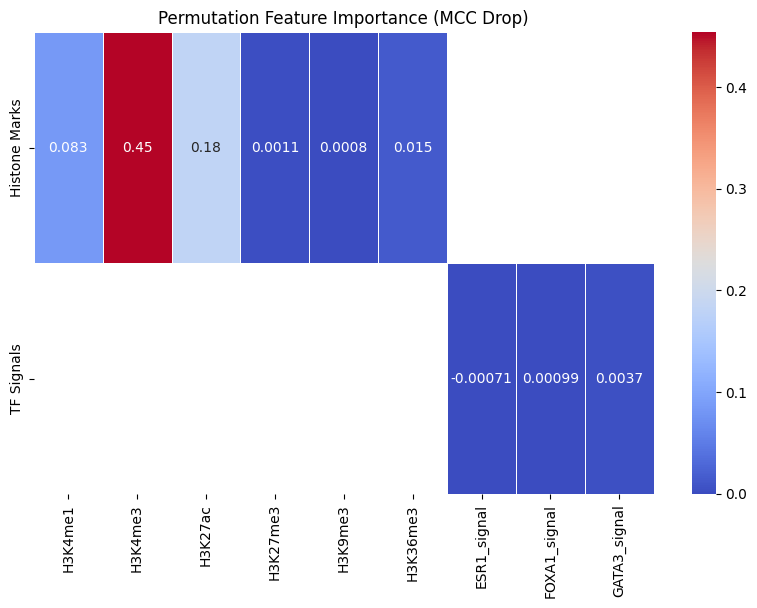

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

# Function to compute permutation importance (MCC Drop)
def permutation_importance(model, X_hist, X_tf, y, metric=matthews_corrcoef, num_repeats=10):
    """ Compute feature importance by shuffling each feature and measuring MCC drop. """
    
    # Convert to DataFrame to preserve structure
    X_hist_df = pd.DataFrame(X_hist, columns=histone_marks)
    X_tf_df = pd.DataFrame(X_tf, columns=tf_signals)

    # Compute baseline MCC score
    baseline_score = metric(y, (model.predict([X_hist, X_tf]).flatten() > 0.5).astype(int))

    feature_importance = {}

    # Loop through each feature set (Histone Marks & TF Signals)
    for feature_set, X_data, feature_names in zip(["Histone Marks", "TF Signals"], [X_hist_df, X_tf_df], [histone_marks, tf_signals]):
        feature_importance[feature_set] = {}

        for feature in feature_names:
            scores = []
            
            for _ in range(num_repeats):
                X_permuted = X_data.copy()
                
                # Shuffle column `feature` **without breaking structure**
                X_permuted[feature] = np.random.permutation(X_permuted[feature].values)

                # Convert back to NumPy arrays for TensorFlow model prediction
                X_hist_input = X_permuted.values if feature_set == "Histone Marks" else X_hist_df.values
                X_tf_input = X_permuted.values if feature_set == "TF Signals" else X_tf_df.values

                # Compute MCC drop
                permuted_score = metric(y, (model.predict([X_hist_input, X_tf_input]).flatten() > 0.5).astype(int))
                scores.append(baseline_score - permuted_score)  

            feature_importance[feature_set][feature] = np.mean(scores)

    return feature_importance

# Compute feature importance
perm_importance = permutation_importance(model, X_hist_test, X_tf_test, y_test)

# Convert to DataFrame and visualize
importance_df = pd.DataFrame(perm_importance).T
plt.figure(figsize=(10, 6))
sns.heatmap(importance_df, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Permutation Feature Importance (MCC Drop)")
plt.show()

### Baseline LOCO-CV (Histogram Boosting & Linear Regression)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    matthews_corrcoef, brier_score_loss, classification_report, 
    roc_auc_score, fbeta_score, balanced_accuracy_score
)
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", 
           "H3K27me3", "H3K9me3", "H3K36me3", "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Select chromosome for leave-out
leave_out_chromosome = "chr1"  # Change this manually if needed

# Check unique chromosome names in dataset
print("Unique Chromosomes in Dataset:", df["chromosome"].unique())

# Split data: Leave out the chosen chromosome for testing
train_df = df[df["chromosome"] != leave_out_chromosome]
test_df = df[df["chromosome"] == leave_out_chromosome]

# Check class balance in the test set
print(f"\nClass distribution in left-out chromosome {leave_out_chromosome}:")
print(test_df["chromatin_state"].value_counts())

# Undersample majority class in training set
minority_class = train_df[train_df["chromatin_state"] == 1]
majority_class = train_df[train_df["chromatin_state"] == 0]

# Ensure undersampling does not exceed available samples
n_samples = min(len(majority_class), 22500)
majority_class = majority_class.sample(n=n_samples, random_state=42)

train_df_balanced = pd.concat([minority_class, majority_class]).sample(frac=1, random_state=42)

# Extract Features & Target
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]

X_train_histone = train_df_balanced[histone_marks]
X_train_tf = train_df_balanced[tf_signals]
y_train = train_df_balanced["chromatin_state"]

X_test_histone = test_df[histone_marks]
X_test_tf = test_df[tf_signals]
y_test = test_df["chromatin_state"]

# Normalize Features Separately (Prevent Data Leakage)
scaler_histone = StandardScaler().fit(X_train_histone)
scaler_tf = StandardScaler().fit(X_train_tf)

X_train_histone = scaler_histone.transform(X_train_histone)
X_test_histone = scaler_histone.transform(X_test_histone)

X_train_tf = scaler_tf.transform(X_train_tf)
X_test_tf = scaler_tf.transform(X_test_tf)

# Define models
models = {
    "Extra Trees": ExtraTreesClassifier(512, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
}

classification_threshold = 0.3  # Adjust classification threshold

# Store results
results = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Concatenate Histone + TF Features
    X_train_combined = np.hstack((X_train_histone, X_train_tf))
    X_test_combined = np.hstack((X_test_histone, X_test_tf))
    
    # Train model
    model.fit(X_train_combined, y_train)
    
    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_test_probs = model.predict_proba(X_test_combined)[:, 1]
    else:
        y_test_probs = model.decision_function(X_test_combined)
    
    # Apply classification threshold
    y_test_pred = (y_test_probs > classification_threshold).astype(int)
    
    # Compute Metrics
    mcc = matthews_corrcoef(y_test, y_test_pred)
    brier = brier_score_loss(y_test, y_test_probs)
    auc = roc_auc_score(y_test, y_test_probs)
    f2 = fbeta_score(y_test, y_test_pred, beta=2)
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    
    # Classification Report
    class_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    precision, recall, f1_score = class_report['1']['precision'], class_report['1']['recall'], class_report['1']['f1-score']
    
    # Store results
    results.append({
        "Model": model_name,
        "Chromosome": leave_out_chromosome,
        "MCC": mcc,
        "Brier Score": brier,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "F2 Score": f2,
        "Balanced Accuracy": balanced_acc,
    })
    
    # Print classification report
    print(f"\nEvaluation for {model_name} on Chromosome {leave_out_chromosome}:")
    print(classification_report(y_test, y_test_pred, zero_division=0))

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(results_df)

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_11375/1619959443.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Unique Chromosomes in Dataset: ['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4' 'chr5'
 'chr6' 'chr7' 'chr8' 'chr9' 'chrX' 'chrY']

Class distribution in left-out chromosome chr1:
chromatin_state
0    224146
1       403
Name: count, dtype: int64

Training Extra Trees...

Evaluation for Extra Trees on Chromosome chr1:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    224146
           1       0.05      0.96      0.10       403

    accuracy                           0.97    224549
   macro avg       0.53      0.96      0.54    224549
weighted avg       1.00      0.97      0.98    224549


Training Logistic Regression...

Evaluation for Logistic Regression on Chromosome chr1:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    224146
           1       0.04      0.94      0.08       403

    accuracy    

### Multihead Neural Network Leave-Out Chromosome Validation

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_15282/3398750933.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9075 - loss: 0.5021 - val_accuracy: 0.9625 - val_loss: 0.1283
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9595 - loss: 0.1414 - val_accuracy: 0.9669 - val_loss: 0.1140
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9628 - loss: 0.1320 - val_accuracy: 0.9675 - val_loss: 0.1087
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9716 - loss: 0.1062 - val_accuracy: 0.9681 - val_loss: 0.1041
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.1048 - val_accuracy: 0.9669 - val_loss: 0.1029
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9656 - loss: 0.1164 - val_accuracy: 0.9675 - val_loss: 0.1052
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9689 - loss: 0.0982 - val_accuracy: 0.9669 - val_loss: 0.1037
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9664 - loss: 0.1225 - val_accuracy: 0.

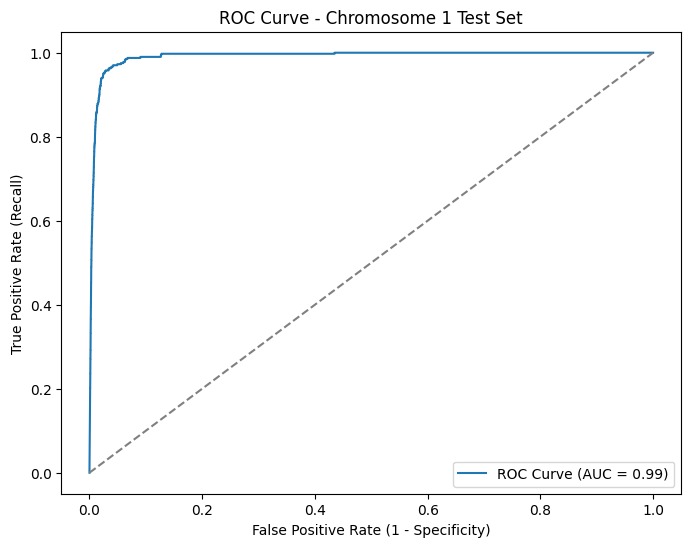

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
           "ESR1_signal", "FOXA1_signal", "GATA3_signal"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Step 1: Leave Out Chromosome 1 for Testing**
train_df = df[df["Chromosome"] != "chr1"]
test_df = df[df["Chromosome"] == "chr1"]

# **Step 2: Properly Balance the Training Set Without Bias**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

# Instead of a fixed 22,500, undersample to maintain the same proportion
ratio = len(minority_class) / len(majority_class)
majority_downsampled = majority_class.sample(frac=ratio, random_state=42)  # Keep the same class ratio

train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)  # Shuffle

# **Step 3: Extract Features & Targets**
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# **Training Data**
X_hist_train, X_tf_train, y_train = train_df_balanced[histone_marks], train_df_balanced[tf_signals], train_df_balanced["chromatin_state"]

# **Test Data (Chromosome 1 is untouched)**
X_hist_test, X_tf_test, y_test = test_df[histone_marks], test_df[tf_signals], test_df["chromatin_state"]

# **Step 4: Normalize Features Per Chromosome**
scaler_histone = MinMaxScaler()
scaler_tf = MinMaxScaler()

# Fit & transform on training set
X_hist_train = scaler_histone.fit_transform(X_hist_train)
X_tf_train = scaler_tf.fit_transform(X_tf_train)

# Transform test set separately (to prevent information leakage)
X_hist_test = scaler_histone.transform(X_hist_test)
X_tf_test = scaler_tf.transform(X_tf_test)

# **Step 5: Define Neural Network Model**
histone_input = Input(shape=(X_hist_train.shape[1],), name="Histone_Input")
histone_dense = Dense(64, activation='relu')(histone_input)
histone_dense = Dropout(0.3)(histone_dense)
histone_dense = Dense(32, activation='relu')(histone_dense)

tf_input = Input(shape=(X_tf_train.shape[1],), name="TF_Input")
tf_dense = Dense(32, activation='relu')(tf_input)
tf_dense = Dropout(0.3)(tf_dense)

merged = Concatenate()([histone_dense, tf_dense])
final_dense = Dense(32, activation='relu')(merged)
final_dense = Dropout(0.3)(final_dense)
out = Dense(1, activation='sigmoid', name="Output")(final_dense)

model = Model(inputs=[histone_input, tf_input], outputs=out)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# **Step 6: Train Model**
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit([X_hist_train, X_tf_train], y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# **Step 7: Evaluate on Chromosome 1 Test Set**
y_test_probs = model.predict([X_hist_test, X_tf_test])
y_test_pred = (y_test_probs > 0.5).astype(int)

# Convert test labels to NumPy arrays before logical operations
y_test_pred = np.array(y_test_pred).flatten()
y_test = np.array(y_test).flatten()

# **Step 8: Compute Final Test Set Metrics**
test_auc = roc_auc_score(y_test, y_test_probs)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)
test_fpr = np.sum((y_test_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

print(f"\nChromosome 1 Test Set Performance")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MCC: {test_mcc:.4f}")
print(f"Test FPR (1 - Specificity): {test_fpr:.4f}")

# **Plot Results**
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Chromosome 1 Test Set")
plt.legend()
plt.show()

## Troubleshooting Low Precision

### UMAP of Class Distribution

<Axes: >

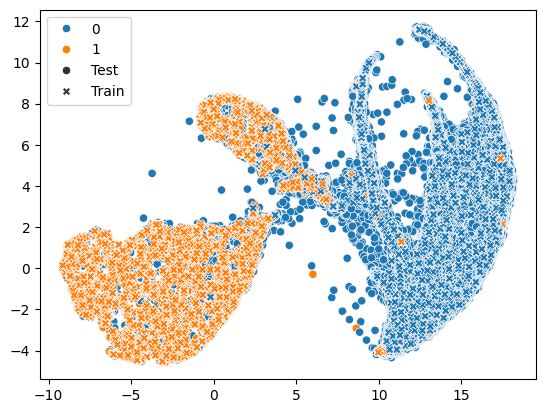

In [8]:
import umap
import seaborn as sns
from matplotlib import pyplot as plt

# Initialize and fit a UMAP model with 2 components using Euclidean distance
trf = umap.UMAP(n_components=2, metric="euclidean").fit(X_hist_train)

# Transform the test set using the trained UMAP model
x_hist_trf = trf.transform(X_hist_test)
# Transform the training set using the same UMAP model
x_hist_tr = trf.transform(X_hist_train)

# Stack the transformed training and test data together vertically
x_all = np.vstack((x_hist_trf, x_hist_tr))

# Create a list of markers labeled "Test" for each sample in the test set
marker = ["Test" for _ in X_hist_test]

# Extend the marker list with "Train" labels for each sample in the training set
marker.extend(["Train" for _ in X_hist_train])

# Create a scatter plot of the transformed data
# - `x_all[:, 0]` and `x_all[:, 1]` represent the first and second UMAP dimensions
# - `hue` colors the points according to the concatenated labels from y_test and y_train
# - `style` differentiates between training and test samples
sns.scatterplot(x=x_all[:, 0], y=x_all[:, 1], hue=np.hstack((y_test, y_train)), style=marker)

<Axes: >

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


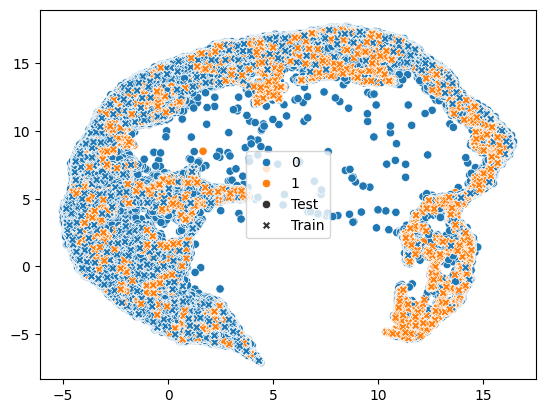

In [9]:
import umap
import seaborn as sns
from matplotlib import pyplot as plt

# Initialize and fit a UMAP model with 2 components using Euclidean distance
trf = umap.UMAP(n_components=2, metric="euclidean").fit(X_tf_train)

# Transform the test set using the trained UMAP model
x_tf_trf = trf.transform(X_tf_test)
# Transform the training set using the same UMAP model
x_tf_tr = trf.transform(X_tf_train)

# Stack the transformed training and test data together vertically
x_all = np.vstack((x_tf_trf, x_tf_tr))

# Create a list of markers labeled "Test" for each sample in the test set
marker = ["Test" for _ in X_tf_test]

# Extend the marker list with "Train" labels for each sample in the training set
marker.extend(["Train" for _ in X_tf_train])

# Create a scatter plot of the transformed data
# - `x_all[:, 0]` and `x_all[:, 1]` represent the first and second UMAP dimensions
# - `hue` colors the points according to the concatenated labels from y_test and y_train
# - `style` differentiates between training and test samples
sns.scatterplot(x=x_all[:, 0], y=x_all[:, 1], hue=np.hstack((y_test, y_tra)), style=marker)

### False Positive Identification and Correction
1. Troubleshooting Approach
__SHAP Analysis__
- Used SHAP to investigate which features contributed to false positive predictions.
- Identified that H3K4me3 had a strong influence on these misclassifications.

2. Histone Signal Tracking
- Plotted H3K4me3 histone mark signals across genomic locations.
- Observed that high histone signals extended beyond labelled peak boundaries.
- Confirmed that many bins should have been labelled as open due to significant signal presence.

3. Dataset Adjustment
- Modified the labelling approach to consider overlapping peaks rather than full containment.
- This adjustment ensured that bins near peak boundaries were correctly labelled as open chromatin.

2025-03-07 09:34:29.197992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_24613/1005457940.py:18: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=",", names=columns)


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9130 - loss: 0.5306 - val_accuracy: 0.9557 - val_loss: 0.1570
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9546 - loss: 0.1638 - val_accuracy: 0.9669 - val_loss: 0.1255
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9630 - loss: 0.1391 - val_accuracy: 0.9669 - val_loss: 0.1169
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.1181 - val_accuracy: 0.9650 - val_loss: 0.1143
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9633 - loss: 0.1229 - val_accuracy: 0.9688 - val_loss: 0.1095
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9699 - loss: 0.1034 - val_accuracy: 0.9688 - val_loss: 0.1083
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9700 - loss: 0.1194 - val_accuracy: 0.9688 - val_loss: 0.1088
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0977 - val_accuracy: 0.

ExactExplainer explainer: 10639it [06:49, 25.83it/s]                           


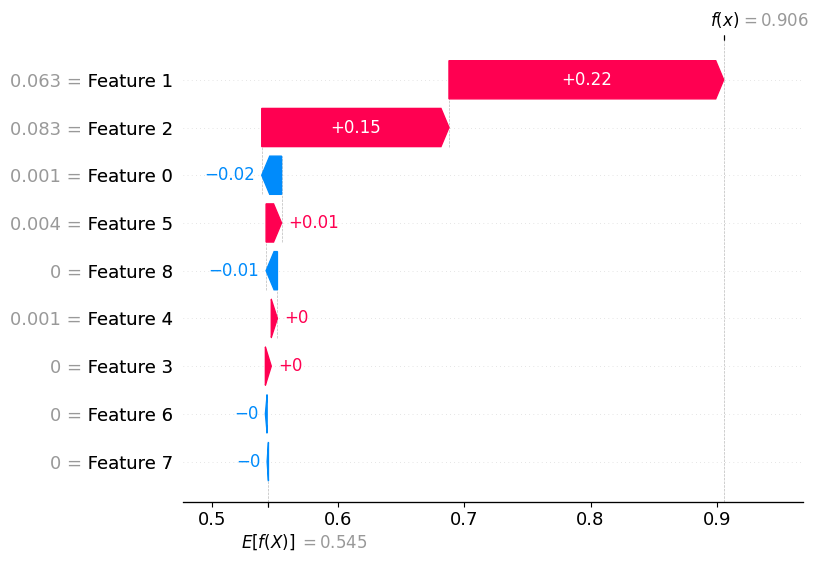

/var/folders/09/0r9l07110lg5nj9ndgsx9kl80000gn/T/ipykernel_24613/1005457940.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["H3K4me3"] = test_df["H3K4me3"].astype(float)  # Ensure numeric


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [1]:
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
columns = ["Chromosome", "Start", "End", "chromatin_state", "H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
           "ESR1_signal", "FOXA1_signal", "GATA3_signal"]
df = pd.read_csv(file_path, sep=",", names=columns)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Step 1: Leave Out Chromosome 1 for Testing**
train_df = df[df["Chromosome"] != "chr1"]
test_df = df[df["Chromosome"] == "chr1"]

# **Step 2: Balance Training Set**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

# Maintain original class ratio
ratio = len(minority_class) / len(majority_class)
majority_downsampled = majority_class.sample(frac=ratio, random_state=42)

train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

# **Step 3: Extract Features & Targets**
histone_marks = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3"]
tf_signals = ["ESR1_signal", "FOXA1_signal", "GATA3_signal"]
all_features = histone_marks + tf_signals

X_train, y_train = train_df_balanced[all_features], train_df_balanced["chromatin_state"]
X_test, y_test = test_df[all_features], test_df["chromatin_state"]

# **Step 4: Normalize Features**
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Step 5: Define Neural Network Model**
input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
dense = Dense(64, activation='relu')(input_layer)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.3)(dense)
output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# **Step 6: Train Model**
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# **Step 7: Get Predictions**
y_test_probs = model.predict(X_test)
threshold = 0.5
y_test_pred = (y_test_probs > threshold).astype(int).flatten()

# Convert to NumPy for analysis
y_test = np.array(y_test)

# **Step 8: Find False Positives (FPs)**
false_positives = (y_test_pred == 1) & (y_test == 0)
X_test_fp = X_test[false_positives]  # Extract FP feature data

print(f"False Positives Found: {X_test_fp.shape[0]}")

# **Step 9: SHAP Analysis (Explain False Positives)**
explainer = shap.Explainer(model, X_train)  # Use training data to fit SHAP model
shap_values = explainer(X_test_fp)

# Plot SHAP Waterfall for a random FP
shap.waterfall_plot(shap_values[0])  # Only show first FP instance
plt.show()

### One Head NN - Leave-One-Chromosome-Out Cross-Validation (LOCO-CV)


Leaving out chr1 for testing...

Test Set Class Distribution (Actual Counts):
chromatin_state
0    224146
1       403
Name: count, dtype: int64

Training Set Class Distribution (Actual Counts) after 5× Downsampling:
chromatin_state
0    20010
1     4002
Name: count, dtype: int64
Epoch 1/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4641 - matthews_correlation: 0.5622 - precision_11: 0.8717 - recall_11: 0.5039 - val_loss: 0.1035 - val_matthews_correlation: 0.8727 - val_precision_11: 0.9220 - val_recall_11: 0.8750
Epoch 2/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1311 - matthews_correlation: 0.8786 - precision_11: 0.9223 - recall_11: 0.8903 - val_loss: 0.0933 - val_matthews_correlation: 0.8851 - val_precision_11: 0.9054 - val_recall_11: 0.9190
Epoch 3/100
801/801 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1288 - matthews_correlation: 0.8784 - precision_11: 0.9150 - recall_11: 0.9181 - val_loss: 0.0962 - val_matthews_correlation: 0.8816 - val_precision_11: 0.9115 - 

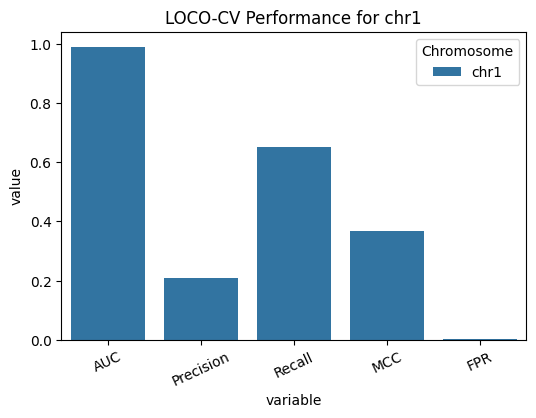

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Encode chromosomes numerically for LOCO splits (but NOT as a feature)
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  # Store original names
df["chromosome"] = df["chromosome"].cat.codes  # Convert to numeric codes

# Select the chromosome to leave out
leave_out_chromosome = "chr1"  # Change this value to test different chromosomes

# Map chromosome name back to its numeric code
if leave_out_chromosome not in chromosome_mapping.values():
    raise ValueError(f"Chromosome {leave_out_chromosome} not found in dataset. Available: {set(chromosome_mapping.values())}")

chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# Split train/test based on the chosen chromosome
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# Check class distribution in test set (Print actual counts)
print("\nTest Set Class Distribution (Actual Counts):")
print(test_df["chromatin_state"].value_counts())

# **Downsample the majority class in the training set to 5× the minority class**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

# Define new majority class size (5× the minority count)
if len(minority_class) > 0:
    n_majority = min(len(majority_class), 5 * len(minority_class))
else:
    n_majority = 10  # Ensure at least 10 majority samples

# Downsample the majority class
majority_downsampled = majority_class.sample(n=n_majority, random_state=42)

# Create balanced training set
train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

# Print actual counts for training set after balancing
print("\nTraining Set Class Distribution (Actual Counts) after 5× Downsampling:")
print(train_df_balanced["chromatin_state"].value_counts())

# Define feature set (EXCLUDING CHROMOSOME)
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# Extract features & target (Chromosome is NOT included)
X_train = train_df_balanced[feature_columns]
y_train = train_df_balanced["chromatin_state"]

X_test = test_df[feature_columns]
y_test = test_df["chromatin_state"]

# Normalize features (Train only)
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define MCC metric for TensorFlow
import tensorflow.keras.backend as K
import tensorflow as tf

def matthews_correlation(y_true, y_pred):
    """ Compute MCC in TensorFlow for model evaluation. """
    y_true = K.cast(y_true, "float32")  # Ensure same data type
    y_pred = K.cast(y_pred, "float32")  # Ensure same data type

    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(y_true)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# Define Neural Network Model (Single Input Head)
input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
dense = Dense(64, activation='relu')(input_layer)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.3)(dense)
output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       matthews_correlation])

class_weights = {0: 2.0, 1: 1.0}

# Train model
batch_size = 24
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    epochs=100, batch_size=batch_size,  
    validation_split=0.2, 
    class_weight=class_weights,
    callbacks=[early_stopping], verbose=1
)

# Model evaluation on left-out chromosome
y_test_probs = model.predict(X_test, batch_size=batch_size)  

# Print raw predictions
print("\nFirst 10 Raw Prediction Probabilities:")
print(y_test_probs[:10])

# Adjust classification threshold
threshold = 0.9
y_test_pred = (y_test_probs > threshold).astype(int).reshape(-1)  

# Compute Metrics (Only if Both Classes Exist)
if len(np.unique(y_test)) > 1:
    test_auc = roc_auc_score(y_test, y_test_probs)
else:
    test_auc = np.nan

test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_mcc = matthews_corrcoef(y_test, y_test_pred) if len(np.unique(y_test_pred)) > 1 else 0

tn = np.sum(y_test == 0)
test_fpr = np.sum((y_test_pred == 1) & (y_test == 0)) / tn if tn > 0 else 0

print(f"\nChromosome {leave_out_chromosome} Test Set Performance")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MCC: {test_mcc:.4f}")

# Store results
results_df = pd.DataFrame([{
    "Chromosome": leave_out_chromosome, 
    "AUC": test_auc, 
    "Precision": test_precision, 
    "Recall": test_recall, 
    "MCC": test_mcc, 
    "FPR": test_fpr
}])

# Display Results
print("\nFinal Results:")
print(results_df)

# Plot Results
plt.figure(figsize=(6, 4))
sns.barplot(data=results_df.melt(id_vars="Chromosome"), x="variable", y="value", hue="Chromosome")
plt.title(f"LOCO-CV Performance for {leave_out_chromosome}")
plt.xticks(rotation=25)
plt.show()

### Hyperparameter Grid Search CV LOCO

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
from itertools import product

# Load dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# Encode chromosomes numerically for LOCO splits (but NOT as a feature)
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))
df["chromosome"] = df["chromosome"].cat.codes

# Select the chromosome to leave out
leave_out_chromosome = "chr1"

# Map chromosome name back to its numeric code
if leave_out_chromosome not in chromosome_mapping.values():
    raise ValueError(f"Chromosome {leave_out_chromosome} not found in dataset. Available: {set(chromosome_mapping.values())}")

chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# Split train/test based on the chosen chromosome
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# Define feature set (EXCLUDING CHROMOSOME)
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

X_test = test_df[feature_columns]
y_test = test_df["chromatin_state"]

# Normalize test set
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

# Define MCC metric for TensorFlow
def matthews_correlation(y_true, y_pred):
    """ Compute MCC in TensorFlow for model evaluation. """
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")

    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(y_true)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# Define custom Focal Loss function
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return K.mean(alpha * K.pow((1 - p_t), gamma) * bce)
    return loss

# Define hyperparameter grid
loss_options = ["binary_crossentropy"]  # Start with binary cross-entropy

# Add focal loss with different alpha and gamma values
alpha_values = [0.25, 0.5, 0.75]
gamma_values = [1.0, 2.0, 3.0]
for alpha, gamma in product(alpha_values, gamma_values):
    loss_options.append(focal_loss(alpha=alpha, gamma=gamma))

class_weight_options = [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}]
downsampling_ratios = [5, 8, 10]
thresholds = [0.5, 0.7, 0.9]

# Store results
results = []

# Grid search loop
for loss_fn, class_weights, downsample_ratio, threshold in product(loss_options, class_weight_options, downsampling_ratios, thresholds):
    print(f"\nTesting: Loss={loss_fn}, Class Weights={class_weights}, Downsampling={downsample_ratio}x, Threshold={threshold}")

    # Downsample training set
    majority_class = train_df[train_df["chromatin_state"] == 0]
    minority_class = train_df[train_df["chromatin_state"] == 1]

    if len(minority_class) > 0:
        n_majority = min(len(majority_class), downsample_ratio * len(minority_class))
    else:
        n_majority = 10  # Ensure at least 10 majority samples

    majority_downsampled = majority_class.sample(n=n_majority, random_state=42)
    train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

    X_train = train_df_balanced[feature_columns]
    y_train = train_df_balanced["chromatin_state"]

    # Normalize training set
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # Define Neural Network Model
    input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
    dense = Dense(64, activation='relu')(input_layer)
    dense = Dropout(0.3)(dense)
    dense = Dense(32, activation='relu')(dense)
    dense = Dropout(0.3)(dense)
    output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_fn,
                  metrics=[tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           matthews_correlation])

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train,
              epochs=50, batch_size=24,
              validation_split=0.2,
              class_weight=class_weights,
              callbacks=[early_stopping], verbose=0)

    # Evaluate model
    y_test_probs = model.predict(X_test, batch_size=24)
    y_test_pred = (y_test_probs > threshold).astype(int).reshape(-1)

    test_auc = roc_auc_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_mcc = matthews_corrcoef(y_test, y_test_pred) if len(np.unique(y_test_pred)) > 1 else 0

    print(f"🎯 Test Results: AUC={test_auc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, MCC={test_mcc:.4f}")

    results.append({"Loss": loss_fn if isinstance(loss_fn, str) else f"Focal (α={alpha}, γ={gamma})",
                    "Class Weights": class_weights, "Downsampling": downsample_ratio,
                    "Threshold": threshold, "AUC": test_auc,
                    "Precision": test_precision, "Recall": test_recall, "MCC": test_mcc})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x="Precision", y="Recall", hue="Loss", style="Downsampling", size="MCC")
plt.axhline(0.7, color='r', linestyle='--')
plt.axvline(0.7, color='r', linestyle='--')
plt.title("Grid Search: Precision vs Recall")
plt.show()


Leaving out chr1 for testing...

Testing: Loss=binary_crossentropy, Class Weights={0: 1, 1: 1}, Downsampling=5x, Threshold=0.5
9357/9357 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
🎯 Test Results: AUC=0.9915, Precision=0.0657, Recall=0.9355, MCC=0.2444

Testing: Loss=binary_crossentropy, Class Weights={0: 1, 1: 1}, Downsampling=5x, Threshold=0.7
9357/9357 ━━━━━━━━━━━━━━━━━━━━ 9s 968us/step
🎯 Test Results: AUC=0.9918, Precision=0.0834, Recall=0.9082, MCC=0.2722

Testing: Loss=binary_crossentropy, Class Weights={0: 1, 1: 1}, Downsampling=5x, Threshold=0.9
9357/9357 ━━━━━━━━━━━━━━━━━━━━ 9s 910us/step
🎯 Test Results: AUC=0.9920, Precision=0.2171, Recall=0.6352, MCC=0.3696

Testing: Loss=binary_crossentropy, Class Weights={0: 1, 1: 1}, Downsampling=8x, Threshold=0.5
9357/9357 ━━━━━━━━━━━━━━━━━━━━ 9s 919us/step
🎯 Test Results: AUC=0.9918, Precision=0.0740, Recall=0.9181, MCC=0.2575

Testing: Loss=binary_crossentropy, Class Weights={0: 1, 1: 1}, Downsampling=8x, Threshold=0.7
9357/9357 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 

## Revising Chromatin State Labeling for Improved Accuracy

### 1. Introduction
The initial approach to chromatin state labeling assigned open chromatin (1) to a bin only if the entire 1000 bp bin was fully contained within an ATAC-seq peak. This strict criterion led to misclassification of partially overlapping bins as closed chromatin (0). As a result, the model was penalized for making correct predictions in cases where a peak extended into a bin but did not fully contain it.

To improve accuracy and reduce false positives, a revised classification rule is introduced. This updated approach assigns a bin as open (1) if there is any overlap between the bin and an ATAC-seq peak.

---

### 2. Previous Labeling Method: Overly Strict Criteria
The previous labeling approach used the following condition to classify bins:

```python
genome_bins.loc[
    (genome_bins["start"] >= row["start"]) & (genome_bins["end"] <= row["end"]),
    "chromatin_state"
] = 1
```

#### 2.1 Why This Was Too Strict
- This condition required an entire 1000 bp bin to be fully enclosed within a peak for it to be labeled as open (1).
- Bins that partially overlapped with an ATAC-seq peak were still assigned as closed (0), even though they contained chromatin accessibility signals.

#### 2.2 Example of Misclassification
Consider an ATAC-seq peak from 198500 bp to 199500 bp and genome bins of 1000 bp each.

| Bin Start  | Bin End  | Peak Start = 198500 | Peak End = 199500 | Labeled Chromatin State (Old Method) | Assigned Correctly? |
|------------|---------|---------------------|-------------------|----------------------------------|------------------|
| 198000     | 199000  | Partially overlaps  | Partially overlaps | 0 (Closed) ❌ | No (Should be Open) ❌ |
| 199000     | 200000  | Fully inside peak   | Fully inside peak  | 1 (Open) ✅ | Yes (Correctly Open) ✅ |
| 200000     | 201000  | Peak ends before bin starts | Not inside at all | 0 (Closed) ✅ | Yes (Correctly Closed) ✅ |

##### Issue with the Previous Method
- The first bin (198000-199000) should be labeled as open (1) because it partially overlaps with the ATAC-seq peak (198500-199500).
- However, under the old method, the bin was labeled as closed (0) because it was not fully contained within the peak.
- The second bin (199000-200000) is correctly labeled as open (1) because it is fully inside the peak.
- The third bin (200000-201000) is correctly labeled as closed (0) because the peak ended before this bin started, so there is no overlap.

##### Why This Causes False Positives
- The first bin contains chromatin accessibility signals but was labeled incorrectly as closed (0).
- The machine learning model may correctly predict it as open (1), but because the label is incorrect, the model is penalized for a "false positive."

By revising the criteria and assigning a bin as open (1) if it overlaps with an ATAC-seq peak at all, we ensure better alignment between labels and biological reality.

---

### 3. Revised Labeling Method: Relaxing the Criteria
To address this issue, the new labeling method assigns open chromatin (1) if there is any overlap between a bin and an ATAC-seq peak:

```python
genome_bins.loc[
    (genome_bins["start"] < row["end"]) & (genome_bins["end"] > row["start"]),
    "chromatin_state"
] = 1
```

#### 3.1 Why This Works
- This method removes the requirement for a bin to be fully contained within a peak.
- If a bin overlaps with an ATAC-seq peak at all, it is now classified as open (1).
- Bins that do not overlap at all remain closed (0).

#### 3.2 Example of Corrected Classification
Using the same ATAC-seq peak (198500-199500 bp) and 1000 bp bins, the new method correctly labels bins as follows:

| Bin Start  | Bin End  | Labeled Chromatin State (New Method) |
|------------|---------|----------------------------------|
| 198000     | 199000  | 1 (Open) ✅ |
| 199000     | 200000  | 1 (Open) ✅ |
| 200000     | 201000  | 0 (Closed) ✅ |

Now, the first bin (198000-199000) is correctly labeled as open (1) because it partially overlaps with the peak.  
The second bin (199000-200000) is fully inside the peak and remains correctly labeled as open (1).  
The third bin (200000-201000) is correctly labeled as closed (0) because the peak ended before this bin began.  

By implementing this correction, the dataset more accurately reflects chromatin accessibility and should reduce false positives in model predictions.

---

### 4. Expected Benefits
- Reduces false positives by ensuring that bins with real ATAC-seq signals are labeled correctly.
- Simplifies classification while maintaining a binary (0 = closed, 1 = open) approach.
- Aligns the model's training labels more closely with biological reality, improving Matthews Correlation Coefficient (MCC) and overall predictive accuracy.

---

### 5. Next Steps
1. Implement the revised labeling function in preprocessing.
2. Retrain the machine learning model using the new labels.
3. Evaluate false positives and MCC improvements using the updated labels.
4. Compare results with the previous model to ensure enhanced classification performance.

This revised method ensures that bins containing chromatin accessibility signals are correctly classified as open (1), reducing the likelihood of false positive predictions.  

### Reassigning Peaks to Final Feature Matrix

In [1]:
import pandas as pd

# Load the final feature matrix
feature_matrix_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix.csv"
feature_matrix = pd.read_csv(feature_matrix_path, sep=",", header=0)

# Load the original ATAC-seq peak data correctly
atac_peaks_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/atac_bulk_IDR.bed"
atac_peaks = pd.read_csv(atac_peaks_path, sep="\t", header=None, usecols=[0, 1, 2], names=["chromosome", "start", "end"])

# Ensure chromosome names match formats
feature_matrix["chromosome"] = feature_matrix["chromosome"].astype(str)
atac_peaks["chromosome"] = atac_peaks["chromosome"].astype(str)

# Debug: Print the first few rows again to confirm it's read correctly
print("\nPreview of Feature Matrix (First 5 Rows):")
print(feature_matrix.head())

print("\nPreview of ATAC-seq Peaks (First 5 Rows):")
print(atac_peaks.head())

# Function to update chromatin state based on relaxed overlap condition
def update_chromatin_state(row, atac_peaks):
    """ Assigns chromatin state (1 if overlaps with an ATAC-seq peak, else 0). """
    overlapping_peaks = atac_peaks[
        (atac_peaks["chromosome"] == row["chromosome"]) &
        (atac_peaks["start"] < row["end"]) & 
        (atac_peaks["end"] > row["start"])
    ]
    return 1 if not overlapping_peaks.empty else 0

# Debug Step 2: Track progress during apply() processing
print("\nUpdating chromatin state column...")

total_rows = len(feature_matrix)
for i, (index, row) in enumerate(feature_matrix.iterrows()):
    feature_matrix.at[index, "chromatin_state"] = update_chromatin_state(row, atac_peaks)
    
    if (i + 1) % 100000 == 0:  # Print progress every 100,000 rows
        print(f"Processed {i + 1}/{total_rows} rows...")

print("\nChromatin state update complete.")

# Count updated chromatin states
updated_counts = feature_matrix["chromatin_state"].value_counts()
num_open = updated_counts.get(1, 0)
num_closed = updated_counts.get(0, 0)

# Debug Step 3: Check a few rows where chromatin_state changed
print("\nChecking updated chromatin state values...")
changed_rows = feature_matrix.sample(n=5)  # Random sample to check assignments
print(changed_rows[["chromosome", "start", "end", "chromatin_state"]])

# Print updated counts
print(f"\nTotal Open (1): {num_open}")
print(f"Total Closed (0): {num_closed}")

# Save the updated feature matrix
updated_feature_matrix_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/updated_feature_matrix.csv"
feature_matrix.to_csv(updated_feature_matrix_path, index=False)

print("\nFeature matrix updated successfully. New chromatin state column assigned.")
print(f"Updated feature matrix saved to: {updated_feature_matrix_path}")


Preview of Feature Matrix (First 5 Rows):
  chromosome  start    end  chromatin_state  H3K4me1   H3K4me3   H3K27ac  \
0       chr1      0   1000                0  0.00021  0.011010  0.000630   
1       chr1   9000  10000                0  0.00021  0.011010  0.133823   
2       chr1  10000  11000                0  0.00021  0.011010  0.287799   
3       chr1  13000  14000                0  0.00021  0.011010  0.000630   
4       chr1  16000  17000                0  0.00021  0.122936  0.022117   

   H3K27me3   H3K9me3  H3K36me3  ESR1_signal  FOXA1_signal  GATA3_signal  
0  0.008930  0.001400  0.000780     0.000750      0.001640      0.014090  
1  0.008930  0.005455  0.000780     0.000750      0.019745      0.014090  
2  0.008930  0.054176  0.002423     0.000750      0.042568      0.014090  
3  0.008930  0.011098  0.002423     0.028817      0.001640      0.014090  
4  0.014908  0.001400  0.123833     0.002666      0.034382      0.057915  

Preview of ATAC-seq Peaks (First 5 Rows):
  chrom

In [2]:
import pandas as pd

# Load the dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/updated_feature_matrix.csv"
df = pd.read_csv(file_path)

# Remove rows where chromosome is "chrY"
df_filtered = df[df["chromosome"] != "chrY"]

# Count open (1) and closed (0) chromatin states
chromatin_state_counts = df_filtered["chromatin_state"].value_counts()

# Print results
print(f"Total Open (1): {chromatin_state_counts.get(1, 0)}")
print(f"Total Closed (0): {chromatin_state_counts.get(0, 0)}")

Total Open (1): 143817
Total Closed (0): 2661272


### Final Model Tests and Grid Search for Hyperparamter Tuning


Leaving out chr1 for testing...

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.3, Downsampling=5x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 649us/step
Results: AUC=0.9228, AUPRC=0.6418, Precision=0.1733, Recall=0.9149, MCC=0.3265

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.3, Downsampling=10x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 756us/step
Results: AUC=0.9258, AUPRC=0.6510, Precision=0.1912, Recall=0.9062, MCC=0.3499

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.3, Downsampling=15x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 678us/step
Results: AUC=0.9251, AUPRC=0.6520, Precision=0.2176, Recall=0.8893, MCC=0.3796

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.5, Downsampling=5x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 5s 672us/step
Results: AUC=0.9236, AUPRC=0.6440, Precision=0.2155, Recall=0.8885, MCC=0.3767

Testing: Class Weights={0: 1, 1: 16.00484664899659}, Threshold=0.5, Downsampling=10x
7018/7018 ━━━━━━━━━━━━━━━━━━━━ 6s 811us/ste

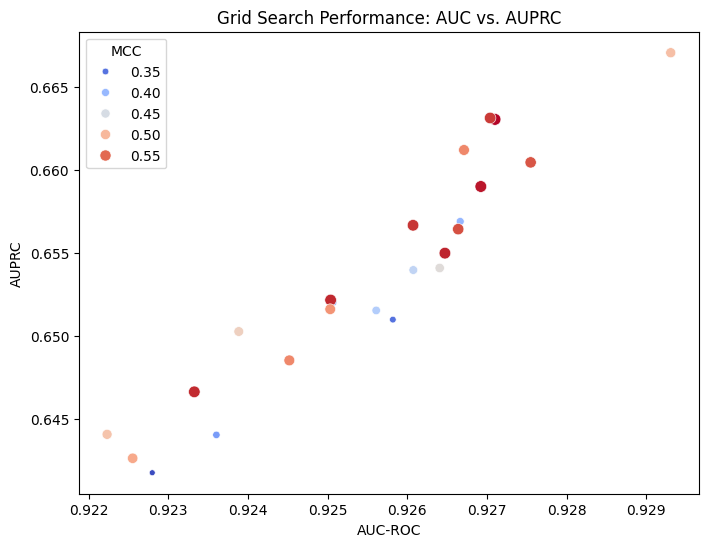

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
from itertools import product  # For hyperparameter combinations

# **Define MCC for TensorFlow**
def matthews_correlation(y_true, y_pred):
    """ Compute MCC in TensorFlow for real-time model evaluation. """
    y_true = K.cast(y_true, "float32")
    y_pred = K.round(K.cast(y_pred, "float32"))

    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# **Load dataset**
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/updated_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Encode chromosomes numerically for LOCO splits**
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  
df["chromosome"] = df["chromosome"].cat.codes  

# **Select the chromosome to leave out**
leave_out_chromosome = "chr1"

# Map chromosome name back to its numeric code
chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# **Split train/test based on the chosen chromosome**
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# **Check class distribution in the test set**
test_class_counts = test_df["chromatin_state"].value_counts(normalize=True)
test_ratio = test_class_counts[1] / test_class_counts[0]  

# **Define hyperparameter grid**
class_weight_options = [{0: 1, 1: 1/test_ratio}, {0: 1, 1: 2}]
threshold_options = [0.3, 0.5, 0.7, 0.9]
downsampling_ratios = [5, 10, 15]

# **Feature Columns**
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# **Hyperparameter Grid Search Loop**
results = []  # Store results

for class_weights, threshold, downsample_ratio in product(class_weight_options, threshold_options, downsampling_ratios):
    print(f"\nTesting: Class Weights={class_weights}, Threshold={threshold}, Downsampling={downsample_ratio}x")

    # **Downsample Majority Class**
    majority_class = train_df[train_df["chromatin_state"] == 0]
    minority_class = train_df[train_df["chromatin_state"] == 1]

    n_majority = min(len(majority_class), downsample_ratio * len(minority_class))
    majority_downsampled = majority_class.sample(n=n_majority, random_state=42)

    train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

    # **Extract Features & Targets**
    X_train = train_df_balanced[feature_columns]
    y_train = train_df_balanced["chromatin_state"]
    X_test = test_df[feature_columns]
    y_test = test_df["chromatin_state"]

    # **Normalize Features**
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # **Define Neural Network Model**
    input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
    dense = Dense(64, activation='relu')(input_layer)
    dense = Dropout(0.3)(dense)
    dense = Dense(32, activation='relu')(dense)
    dense = Dropout(0.3)(dense)
    output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="binary_crossentropy", 
                  metrics=[tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall(), 
                           matthews_correlation])

    # **Train Model**
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train, 
        epochs=50, batch_size=32,  
        validation_split=0.2, 
        class_weight=class_weights,
        callbacks=[early_stopping], verbose=0
    )

    # **Evaluate Model**
    y_test_probs = model.predict(X_test, batch_size=32)
    y_test_pred = (y_test_probs > threshold).astype(int).reshape(-1)

    # **Compute Metrics**
    test_auc = roc_auc_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_mcc = matthews_corrcoef(y_test, y_test_pred) if len(np.unique(y_test_pred)) > 1 else 0
    test_auprc = average_precision_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan

    # **Print Results Immediately**
    print(f"Results: AUC={test_auc:.4f}, AUPRC={test_auprc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, MCC={test_mcc:.4f}")

    # **Store results**
    results.append({
        "Class Weights": class_weights, "Threshold": threshold, "Downsampling": downsample_ratio,
        "AUC": test_auc, "AUPRC": test_auprc, "Precision": test_precision, "Recall": test_recall, "MCC": test_mcc
    })

# **Convert results into a DataFrame**
results_df = pd.DataFrame(results)

# **Display Final Results**
print("\nFinal Grid Search Results:")
print(results_df.sort_values(by=["MCC"], ascending=False).to_string(index=False))

# **Plot AUC vs. AUPRC**
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="AUC", y="AUPRC", hue="MCC", size="MCC", palette="coolwarm", legend=True)
plt.xlabel("AUC-ROC")
plt.ylabel("AUPRC")
plt.title("Grid Search Performance: AUC vs. AUPRC")
plt.show()

### Final Model


Leaving out chr1 for testing...

Test Set Class Distribution (Actual Counts):
chromatin_state
0    211344
1     13205
Name: count, dtype: int64
Epoch 1/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 0.3973 - matthews_correlation: 0.6141 - precision_27: 0.7258 - recall_27: 0.6742 - val_loss: 0.2791 - val_matthews_correlation: 0.6367 - val_precision_27: 0.6423 - val_recall_27: 0.7957
Epoch 2/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.3503 - matthews_correlation: 0.6491 - precision_27: 0.6929 - recall_27: 0.7529 - val_loss: 0.2500 - val_matthews_correlation: 0.6469 - val_precision_27: 0.6724 - val_recall_27: 0.7753
Epoch 3/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.3452 - matthews_correlation: 0.6540 - precision_27: 0.7026 - recall_27: 0.7486 - val_loss: 0.2320 - val_matthews_correlation: 0.6569 - val_precision_27: 0.7363 - val_recall_27: 0.7217
Epoch 4/50
26123/26123 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 0.3436 - matthews_correlation: 0.6510

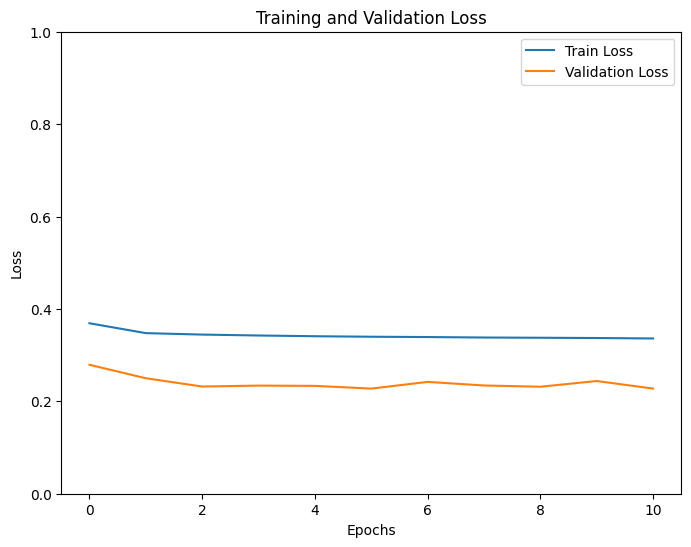

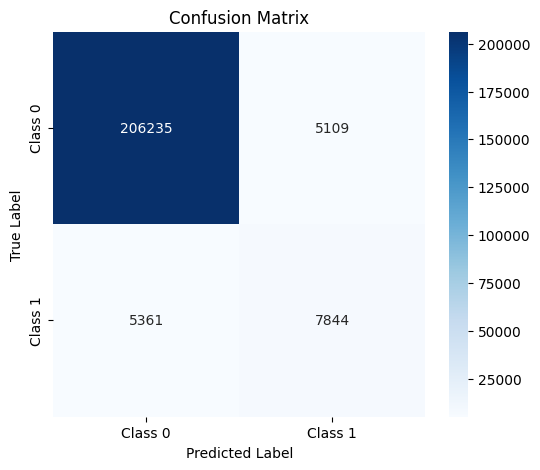

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, matthews_corrcoef, average_precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K

# **Define MCC Metric for TensorFlow**
def matthews_correlation(y_true, y_pred):
    """ Compute MCC in TensorFlow for model evaluation. """
    y_true = K.cast(y_true, "float32")
    y_pred = K.round(K.cast(y_pred, "float32"))

    tp = K.sum(y_true * y_pred)
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# **Load dataset**
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/updated_feature_matrix.csv"
df = pd.read_csv(file_path, sep=",", header=0)

# Ensure chromatin_state is numeric
df["chromatin_state"] = pd.to_numeric(df["chromatin_state"], errors="coerce")
df = df.dropna(subset=["chromatin_state"])
df["chromatin_state"] = df["chromatin_state"].astype(int)

# **Encode chromosomes numerically for LOCO splits**
df["chromosome"] = df["chromosome"].astype("category")
chromosome_mapping = dict(enumerate(df["chromosome"].cat.categories))  
df["chromosome"] = df["chromosome"].cat.codes  

# **Select the chromosome to leave out**
leave_out_chromosome = "chr1"

# Map chromosome name back to its numeric code
chrom_num = [num for num, name in chromosome_mapping.items() if name == leave_out_chromosome][0]

print(f"\nLeaving out {leave_out_chromosome} for testing...")

# **Split train/test based on the chosen chromosome**
train_df = df[df["chromosome"] != chrom_num]
test_df = df[df["chromosome"] == chrom_num]

# **Check class distribution in test set**
print("\nTest Set Class Distribution (Actual Counts):")
print(test_df["chromatin_state"].value_counts())

# **Downsample the majority class in the training set to 5× the minority class**
majority_class = train_df[train_df["chromatin_state"] == 0]
minority_class = train_df[train_df["chromatin_state"] == 1]

# Define new majority class size (5× the minority count)
if len(minority_class) > 0:
    n_majority = min(len(majority_class), 5 * len(minority_class))
else:
    n_majority = 10  

# Downsample the majority class
majority_downsampled = majority_class.sample(n=n_majority, random_state=42)

# Create balanced training set
train_df_balanced = pd.concat([majority_downsampled, minority_class]).sample(frac=1, random_state=42)

# **Feature Columns**
feature_columns = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K9me3", "H3K36me3",
                   "ESR1_signal", "FOXA1_signal", "GATA3_signal"]

# **Extract Features & Targets**
X_train = train_df_balanced[feature_columns]
y_train = train_df_balanced["chromatin_state"]
X_test = test_df[feature_columns]
y_test = test_df["chromatin_state"]

# **Normalize Features**
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **Define Neural Network Model**
input_layer = Input(shape=(X_train.shape[1],), name="Feature_Input")
dense = Dense(64, activation='relu')(input_layer)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(0.3)(dense)
output_layer = Dense(1, activation='sigmoid', name="Output")(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss="binary_crossentropy", 
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), 
                       matthews_correlation])

class_weights = {0:1, 1:2}

# **Train Model**
batch_size = 24
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    epochs=50, batch_size=batch_size,  
    validation_split=0.2, 
    class_weight=class_weights,
    callbacks=[early_stopping], verbose=1
)

# **Model Evaluation**
y_test_probs = model.predict(X_test, batch_size=batch_size)
y_test_pred = (y_test_probs > 0.7).astype(int).reshape(-1)  

# **Compute Metrics**
test_auc = roc_auc_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_mcc = matthews_corrcoef(y_test, y_test_pred) if len(np.unique(y_test_pred)) > 1 else 0
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_auprc = average_precision_score(y_test, y_test_probs) if len(np.unique(y_test)) > 1 else np.nan

# **False Positive Rate Calculation**
tn = np.sum(y_test == 0)
test_fpr = np.sum((y_test_pred == 1) & (y_test == 0)) / tn if tn > 0 else 0

# **Print Evaluation Metrics**
print(f"\nChromosome {leave_out_chromosome} Test Set Performance")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test AUPRC: {test_auprc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MCC: {test_mcc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test FPR (1 - Specificity): {test_fpr:.4f}")

# **Plot Loss Curves**
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 1)  # Ensuring Y-axis is between 0 and 1
plt.legend()
plt.show()

# **Confusion Matrix**
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()